In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import math
import os.path
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pylab import mpl
from six.moves import xrange
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim 
from im2txt import configuration
from im2txt import show_and_tell_model
from im2txt import configuration
from im2txt import inference_wrapper  
from tensorflow.python.tools import inspect_checkpoint as chkp
%matplotlib inline

In [2]:
model_path_dir = '.\modelSave1'
word_path = '.\wordCount\word_counts.txt'

In [3]:
dictionary_1 = {}
with open(word_path,"r") as f:
    lines = f.readlines()
    txt_len = len(lines) 
    for i in range(txt_len):
        dic_key = lines[i].rstrip().split(" ")[0]
        dictionary_1[dic_key] = i 

In [4]:
dic_len = len(dictionary_1)
dictionary_1["unk"] = dic_len

In [5]:
reversed_dictionary = dict(zip(dictionary_1.values(), dictionary_1.keys()))

In [6]:
model_path = tf.train.latest_checkpoint(model_path_dir)
model_config = configuration.ModelConfig()
model_shape =[model_config.vocab_size, model_config.embedding_size]

In [7]:
model_shape

[12000, 512]

In [8]:
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
#随机选取0-100 中的16个不重复的数，每个数的概率都是一样的
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [9]:
g = tf.Graph()
with g.as_default():
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    model = show_and_tell_model.ShowAndTellModel(model_config, mode="inference")
    model.build()
    seq_embeddings = model.total_seq_embeddings
    norm = tf.sqrt(tf.reduce_sum(tf.square(seq_embeddings), 1, keepdims=True))
    # 正则化词向量权重
    normalized_embeddings = seq_embeddings / norm
    # 根据验证数据集找到对应的词向量
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings,valid_dataset)
    # 计算余弦相似性 
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
    
    saver = tf.train.Saver()
    # sv = tf.train.Supervisor(logdir=model_path)
    with tf.Session(graph=g) as sess:
        saver.restore(sess, model_path)
    #     sim_val = sess.run([similarity],feed_dict={valid_dataset:valid_examples})
        embed = sess.run([seq_embeddings])
        final_embeddings = normalized_embeddings.eval()

INFO:tensorflow:Restoring parameters from D:\MSCOCODATA\trainDir\model.ckpt-200000


In [10]:
print(final_embeddings)

[[ 0.01361513 -0.00201733 -0.0032677  ... -0.02816183 -0.01826471
  -0.02518272]
 [-0.04847866 -0.06205237 -0.02657469 ... -0.0651807   0.04966953
  -0.02576275]
 [-0.03468073  0.05220807 -0.05279056 ...  0.04095721  0.00797601
   0.0039763 ]
 ...
 [-0.01660199  0.03217962 -0.02848045 ...  0.03300962 -0.00656709
   0.00285041]
 [ 0.07240407 -0.06653936 -0.05836784 ...  0.05133528 -0.04239774
  -0.01296649]
 [ 0.06403261  0.01456837 -0.02720509 ...  0.04832717 -0.02475705
  -0.0374524 ]]


In [11]:
# pylint: disable=missing-docstring
# Function to draw visualization of distance between embeddings.
def plot_with_labels(low_dim_embs, labels, filename):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

    plt.savefig(filename)

In [12]:
final_embeddings[:500,:]

array([[ 0.01361513, -0.00201733, -0.0032677 , ..., -0.02816183,
        -0.01826471, -0.02518272],
       [-0.04847866, -0.06205237, -0.02657469, ..., -0.0651807 ,
         0.04966953, -0.02576275],
       [-0.03468073,  0.05220807, -0.05279056, ...,  0.04095721,
         0.00797601,  0.0039763 ],
       ...,
       [ 0.01181581,  0.01516159, -0.07006816, ...,  0.07091527,
         0.05331072,  0.06796015],
       [-0.02966832,  0.04211997,  0.05200255, ...,  0.04704409,
        -0.01051826, -0.07310561],
       [-0.04548951,  0.05892007, -0.0738551 , ..., -0.00841201,
        -0.03182682, -0.0354587 ]], dtype=float32)

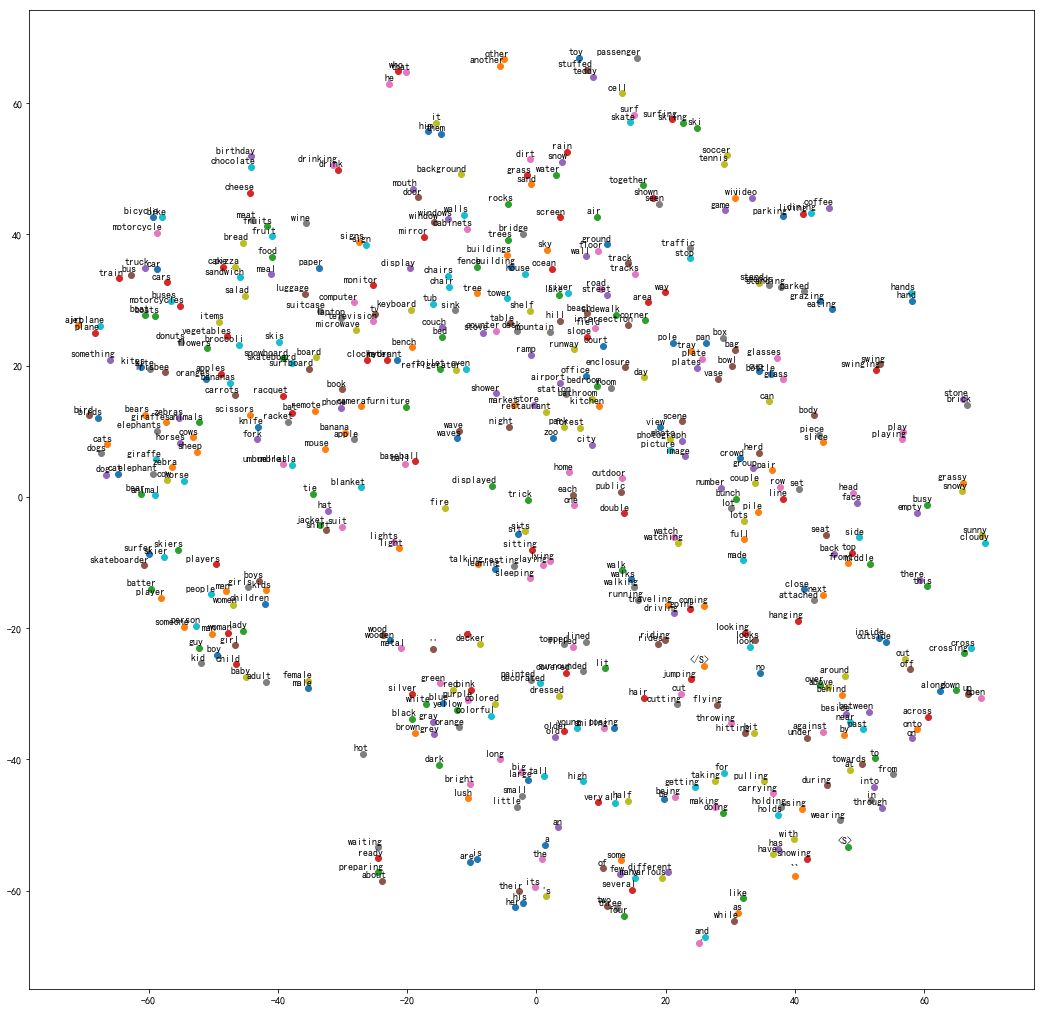

In [13]:
try:
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体：解决plot不能显示中文问题
    mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reversed_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels, os.path.join('', 'tsne.png'))

except ImportError as ex:
    print('Please install sklearn, matplotlib, and scipy to show embeddings.')
    print(ex)